# Validation

### Helpers

In [1]:
# import libraries
import os
import ROOT
import numpy as np

Welcome to JupyROOT 6.18/00


In [2]:
# color palette
blue = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 31., 119., 180.)
orange = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 255., 127., 14.)
green = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 44., 160., 44.)
red = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 214., 39., 40.)
purple = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 148., 103., 189.)
palette = {'blue': blue, 'orange': orange, 'green': green, 'red': red, 'purple': purple}

In [3]:
def leakageCorrection(col):
    return f"{col}*PrimaryParticleEnergy/(PrimaryParticleEnergy-EscapedEnergy)"

def modifiedZscore(rdf, col, D=3.5):
    x = rdf.AsNumpy(columns=[col])[col]
    xtilde = np.median(x)
    MAD = np.median(np.abs(x-xtilde))
    return f"abs(0.6745*({col}-({xtilde}))/{MAD}) <= {D}"

### Create dataframe

In [4]:
# create rdataframe
treeName = "B4"
path = "/groups/hep/mojen/repositories/DREAM/Run"
fileName = os.path.join(path, "B4.root")
rdf = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
# define new columns
rdf = rdf.Define("VectorSignals_cal", leakageCorrection("VectorSignals"))
rdf = rdf.Define("VectorSignalsCher_cal", leakageCorrection("VectorSignalsCher"))
rdf = rdf.Define("Ssum", "Sum(VectorSignals_cal)")
rdf = rdf.Define("Csum", "Sum(VectorSignalsCher_cal)")

### Calibration

In [5]:
rdf_e = rdf.Range(100)
rdf_eS = rdf_e.Filter("Ssum > 0.", "Cut1").Define("Snorm", "PrimaryParticleEnergy/Ssum")
rdf_eC = rdf_e.Filter("Csum > 0.", "Cut1").Define("Cnorm", "PrimaryParticleEnergy/Csum")
# modified Z score
rdf_eS = rdf_eS.Filter(modifiedZscore(rdf_eS, "Snorm"), "Cut2")
rdf_eC = rdf_eC.Filter(modifiedZscore(rdf_eC, "Cnorm"), "Cut2")
# print cuts report
cutsReport_eS = rdf_eS.Report()
cutsReport_eS.Print()
cutsReport_eC = rdf_eC.Report()
cutsReport_eC.Print()

Cut1      : pass=100        all=100        -- eff=100.00 % cumulative eff=100.00 %
Cut2      : pass=81         all=100        -- eff=81.00 % cumulative eff=81.00 %
Cut1      : pass=100        all=100        -- eff=100.00 % cumulative eff=100.00 %
Cut2      : pass=82         all=100        -- eff=82.00 % cumulative eff=82.00 %


 FCN=25.1536 FROM MIGRAD    STATUS=CONVERGED     173 CALLS         174 TOTAL
                     EDM=7.41978e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.76775e+00   3.25788e-01   5.90774e-04  -1.51756e-05
   2  Mean         2.59639e+01   8.86060e-01   1.71309e-03   4.25334e-05
   3  Sigma        2.64399e+00   1.46190e+00   4.62159e-04   1.51399e-06
 FCN=18.2356 FROM MIGRAD    STATUS=CONVERGED     109 CALLS         110 TOTAL
                     EDM=2.34033e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.13245e+00   5.30232e-01   5.71841e-04  -1.13973e-04
   2  Mean         2.61905e+01   4.32153e-01   8.82835e-04  -2.14734e-05
   3  Sigma        2.20051e+00   

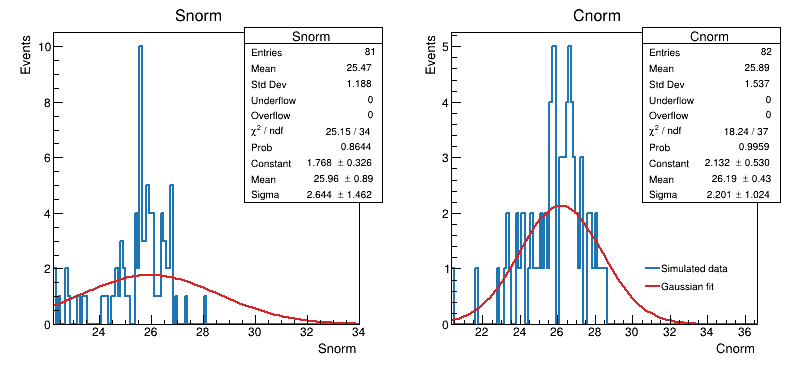

In [6]:
c1 = ROOT.TCanvas("c", "c", 800, 400)
c1.Divide(2)
col = ["Snorm", "Cnorm"]
d = [rdf_eS, rdf_eC]
h = [None, None]
mean = [None, None]
for i in range(len(col)):
    c1.cd(i+1)
    ROOT.gStyle.SetOptStat("nemr ou")
    ROOT.gStyle.SetOptFit(1111)
    ROOT.gPad.SetLeftMargin(0.12)
    ROOT.gPad.SetBottomMargin(0.12)
    ROOT.gPad.SetRightMargin(0.08)
    ROOT.gPad.SetTopMargin(0.08)
    h[i] = d[i].Histo1D(col[i])
    h[i].GetXaxis().SetTitle(col[i])
    h[i].GetXaxis().SetTitleSize(0.04)
    h[i].GetYaxis().SetTitle("Events")
    h[i].GetYaxis().SetTitleSize(0.04)
    h[i].DrawCopy("E1")
    r = h[i].Fit("gaus", "S")
    h[i].SetLineColor(palette['blue'].GetNumber())
    h[i].SetLineWidth(2)
    gaus = h[i].GetFunction("gaus")
    gaus.SetLineColor(palette['red'].GetNumber())
    gaus.SetLineWidth(2)
    mean[i] = r.Parameter(1)
    rms = r.Parameter(2)
    # add legend
    legend = ROOT.TLegend(0.62, 0.2, 0.82, 0.3)
    legend.SetFillColor(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.AddEntry(h[i].GetValue(), "Simulated data", "l")
    legend.AddEntry(gaus, "Gaussian fit", "l")
    legend.Draw()
    
ROOT.gPad.Modified()
ROOT.gPad.Update()
c1.Draw()

S_cal = mean[0]
C_cal = mean[1]

### Chi

In [7]:
rdf2 = rdf
rdf2 = rdf2.Define("Ssum_cal", f"Ssum*{S_cal}")
rdf2 = rdf2.Define("Csum_cal", f"Csum*{C_cal}")
rdf2 = rdf2.Filter("PrimaryParticleEnergy > 0.").Define("Snorm_cal", "Ssum_cal/PrimaryParticleEnergy")
rdf2 = rdf2.Define("Cnorm_cal", "Csum_cal/PrimaryParticleEnergy")
rdf2 = rdf2.Define("chi", "(1-Snorm_cal)/(1-Cnorm_cal)")
rdf2_e = rdf2.Range(100)
rdf2_pi = rdf2.Range(100, 200)

In [8]:
# modified Z score
rdf2_pi = rdf2_pi.Filter(modifiedZscore(rdf2_pi, "chi"), "Cut2")
# print cuts report
cutsReport_eS = rdf_eS.Report()
cutsReport_eS.Print()

Cut1      : pass=100        all=100        -- eff=100.00 % cumulative eff=100.00 %
Cut2      : pass=81         all=100        -- eff=81.00 % cumulative eff=81.00 %


 FCN=23.396 FROM MIGRAD    STATUS=CONVERGED     106 CALLS         107 TOTAL
                     EDM=4.03147e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.04307e+00   3.30001e-01   6.03784e-04   9.47063e-04
   2  Mean         3.37425e-01   5.07791e-02   1.22338e-04   5.51007e-04
   3  Sigma        2.42260e-01   7.40936e-02   2.66732e-04   2.43847e-03


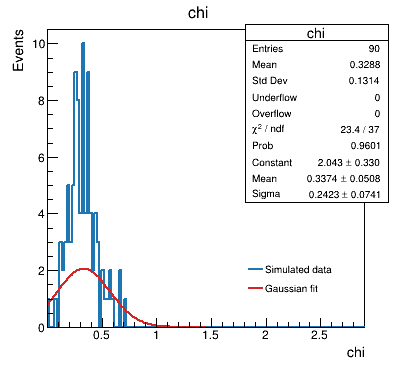

In [9]:
c2 = ROOT.TCanvas("c", "c", 400, 400)
col = ["chi"]
d = [rdf2_pi]
h = [None]
mean = [None]
for i in range(len(col)):
    c2.cd(i+1)
    ROOT.gStyle.SetOptStat("nemr ou")
    ROOT.gStyle.SetOptFit(1111)
    ROOT.gPad.SetLeftMargin(0.12)
    ROOT.gPad.SetBottomMargin(0.12)
    ROOT.gPad.SetRightMargin(0.08)
    ROOT.gPad.SetTopMargin(0.08)
    h[i] = d[i].Histo1D(col[i])
    h[i].GetXaxis().SetTitle(col[i])
    h[i].GetXaxis().SetTitleSize(0.04)
    h[i].GetYaxis().SetTitle("Events")
    h[i].GetYaxis().SetTitleSize(0.04)
    h[i].DrawCopy("E1")
    r = h[i].Fit("gaus", "S")
    h[i].SetLineColor(palette['blue'].GetNumber())
    h[i].SetLineWidth(2)
    gaus = h[i].GetFunction("gaus")
    gaus.SetLineColor(palette['red'].GetNumber())
    gaus.SetLineWidth(2)
    mean[i] = r.Parameter(1)
    rms = r.Parameter(2)
    # add legend
    legend = ROOT.TLegend(0.62, 0.2, 0.82, 0.3)
    legend.SetFillColor(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.AddEntry(h[i].GetValue(), "Simulated data", "l")
    legend.AddEntry(gaus, "Gaussian fit", "l")
    legend.Draw()
    
ROOT.gPad.Modified()
ROOT.gPad.Update()
c2.Draw()

chi = mean[0]

### C/E vs S/E

In [10]:
gr1 = rdf2_e.Graph("Snorm_cal", "Cnorm_cal")
gr2 = rdf2_pi.Graph("Snorm_cal", "Cnorm_cal")

gr1.SetMarkerColor(palette['blue'].GetNumber())
gr2.SetMarkerColor(palette['red'].GetNumber())
gr1.SetMarkerStyle(ROOT.kFullDotSmall)
gr2.SetMarkerStyle(ROOT.kFullDotSmall)

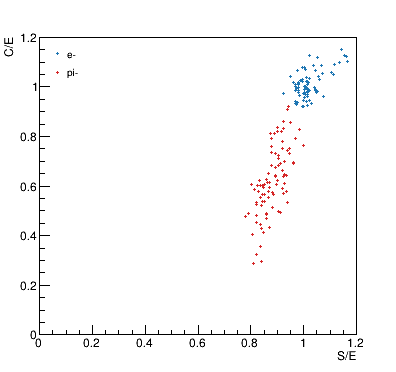

In [11]:
c3 = ROOT.TCanvas("c2", "c2", 400, 400)
mg = ROOT.TMultiGraph()
mg.Add(gr1.GetPtr())
mg.Add(gr2.GetPtr())
mg.Draw("ap")

# axis settings
mg.GetXaxis().SetLimits(0., 1.2)
mg.GetYaxis().SetRangeUser(0., 1.2)
mg.GetXaxis().SetTitle("S/E")
mg.GetYaxis().SetTitle("C/E")

# add legend
legend = ROOT.TLegend(0.12, 0.78, 0.32, 0.88)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.03)
legend.AddEntry(gr1.GetValue(), "e-", "p")
legend.AddEntry(gr2.GetValue(), "pi-", "p")
legend.Draw()

ROOT.gPad.Modified()
ROOT.gPad.Update()
c3.Draw()